In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier

import warnings

warnings.filterwarnings('ignore')
sns.set_style(style='darkgrid')

import pickle

### Dataset

In [3]:
data = pd.read_csv('data/Heart Attack.csv')
data.head()

,age,gender,impluse,pressurehight,pressurelow,glucose,kcm,troponin,class
0,64,1,66,160,83,160.0,1.80,0.012,negative
1,21,1,94,98,46,296.0,6.75,1.060,positive
2,55,1,64,160,77,270.0,1.99,0.003,negative
3,64,1,70,120,55,270.0,13.87,0.122,positive
4,55,1,64,112,65,300.0,1.08,0.003,negative


In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319 entries, 0 to 1318
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   age            1319 non-null   int64  
 1   gender         1319 non-null   int64  
 2   impluse        1319 non-null   int64  
 3   pressurehight  1319 non-null   int64  
 4   pressurelow    1319 non-null   int64  
 5   glucose        1319 non-null   float64
 6   kcm            1319 non-null   float64
 7   troponin       1319 non-null   float64
 8   class          1319 non-null   object 
dtypes: float64(3), int64(5), object(1)
memory usage: 92.9+ KB


In [5]:
data.describe()

,age,gender,impluse,pressurehight,pressurelow,glucose,kcm,troponin
count,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000
mean,56.191812,0.659591,78.336619,127.170584,72.269143,146.634344,15.274306,0.360942
std,13.647315,0.474027,51.630270,26.122720,14.033924,74.923045,46.327083,1.154568
min,14.000000,0.000000,20.000000,42.000000,38.000000,35.000000,0.321000,0.001000
25%,47.000000,0.000000,64.000000,110.000000,62.000000,98.000000,1.655000,0.006000
50%,58.000000,1.000000,74.000000,124.000000,72.000000,116.000000,2.850000,0.014000
75%,65.000000,1.000000,85.000000,143.000000,81.000000,169.500000,5.805000,0.085500
max,103.000000,1.000000,1111.000000,223.000000,154.000000,541.000000,300.000000,10.300000


### Some basic plots and preprocessing

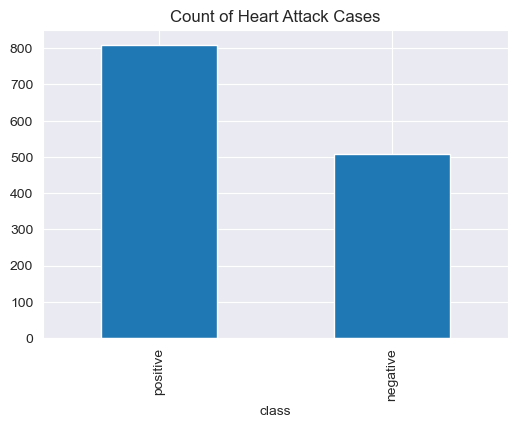

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax = data['class'].value_counts().plot(kind='bar')

ax.set_title('Count of Heart Attack Cases');

Checking some columns for outliers

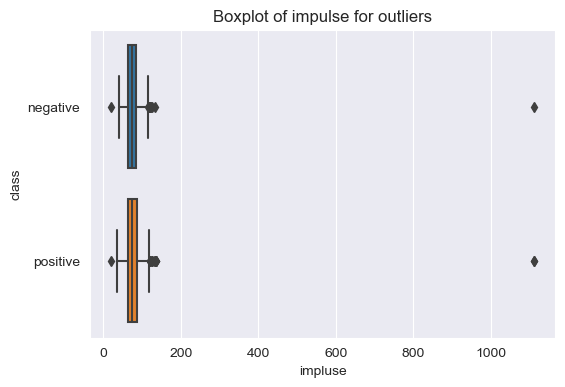

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

sns.boxplot(data=data, x='impluse', y='class', ax=ax)
ax.set_title('Boxplot of impulse for outliers');

In [30]:
# Removing data with impulse > 1000 which might be noise.
data2 = data[data.impluse<1000]

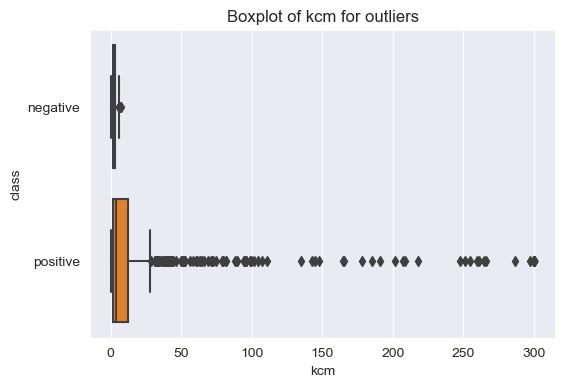

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

sns.boxplot(data=data2, x='kcm', y='class', ax=ax)
ax.set_title('Boxplot of kcm for outliers');

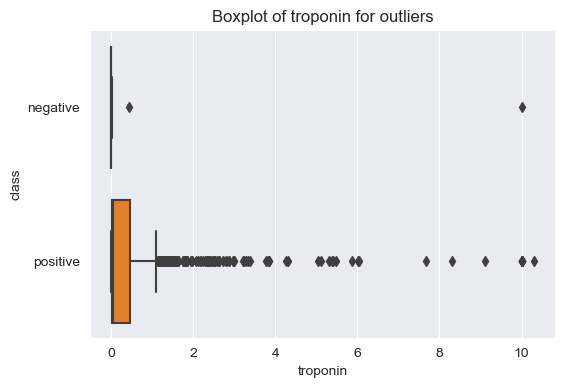

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

sns.boxplot(data=data2, x='troponin', y='class', ax=ax)
ax.set_title('Boxplot of troponin for outliers');

In [42]:
d1 = data2[data2['class']=='negative']
d2 = d1[d1['troponin'] > 9]
d2

,age,gender,impluse,pressurehight,pressurelow,glucose,kcm,troponin,class
29,63,1,66,135,55,166.0,0.493,10.0,negative


In [43]:
# Removing it
data2.drop(index=29, inplace=True)
data2.reset_index(drop=True, inplace=True)

In [51]:
label = {'positive': 1, 'negative': 0}

data2['class'] = data2['class'].map(label)

In [52]:
data2.head()

,age,gender,impluse,pressurehight,pressurelow,glucose,kcm,troponin,class
0,64,1,66,160,83,160.0,1.80,0.012,0
1,21,1,94,98,46,296.0,6.75,1.060,1
2,55,1,64,160,77,270.0,1.99,0.003,0
3,64,1,70,120,55,270.0,13.87,0.122,1
4,55,1,64,112,65,300.0,1.08,0.003,0


### Splitting data into train and test set

In [53]:
X = data2.drop(columns='class')
y = data2['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
print('Shape of X_Train set : {}'.format(X_train.shape))
print('Shape of y_Train set : {}'.format(y_train.shape))
print('_'*50)
print('Shape of X_test set : {}'.format(X_test.shape))
print('Shape of y_test set : {}'.format(y_test.shape))

Shape of X_Train set : (1052, 8)
Shape of y_Train set : (1052,)
__________________________________________________
Shape of X_test set : (263, 8)
Shape of y_test set : (263,)


### Model Training

In [55]:
# Find best parameters for Random Forest
n_estimators = [10, 50, 100, 250, 500]
criterions = ['gini', 'entropy']
max_depthes = [None, 2,  4, 6, 8]
best_recall = 0.0001

for estimator in n_estimators :
    for criterion in criterions :
        for depth in max_depthes :

            # Modeling
            RF = RandomForestClassifier(n_estimators=estimator, criterion=criterion, 
                                        max_depth=depth, n_jobs=-1)
            RF.fit(X_train, y_train)
            y_pred = RF.predict(X_test)
            # Score
            score = recall_score(y_test, y_pred)
            # Condition to find best parameters
            if (score > best_recall):
                best_recall = score
                best_estimator = estimator
                best_criterion = criterion
                best_depth = depth

print('Best Criterion : ', best_criterion)
print('Best estimator : ', best_estimator)
print('Best depth : ', best_depth)
print('Recall Score : ', best_recall)

Best Criterion :  gini
Best estimator :  10
Best depth :  2
Recall Score :  0.9938271604938271


In [56]:
RF = RandomForestClassifier(n_estimators=best_estimator, criterion=best_criterion, max_depth=best_depth, 
                            n_jobs=-1)
RF.fit(X_train, y_train)
y_pred = RF.predict(X_test)

RF_score = accuracy_score(y_test, y_pred)
RF_score

0.9847908745247148

In [57]:
print('Accuracy Score : ', accuracy_score(y_test, y_pred))
print('Precision Score : ', precision_score(y_test, y_pred))
print('Recall Score : ', recall_score(y_test, y_pred))
print('F1 Score : ', f1_score(y_test,y_pred))

Accuracy Score :  0.9847908745247148
Precision Score :  0.9876543209876543
Recall Score :  0.9876543209876543
F1 Score :  0.9876543209876543


### Feature importance

In [110]:
columns = X.columns
columns

Index(['age', 'gender', 'impluse', 'pressurehight', 'pressurelow', 'glucose',
       'kcm', 'troponin'],
      dtype='object')

In [111]:
importances = RF.feature_importances_

indices = np.argsort(importances)[::-1]
indices

array([7, 6, 0, 5, 3, 4, 2, 1], dtype=int64)

In [113]:
for i in indices:
    print(f'{columns[i]} : {importances[i]}')

troponin : 0.5387258610439722
kcm : 0.271098519647366
age : 0.13948150475240859
glucose : 0.01887521380051477
pressurehight : 0.015396001135234788
pressurelow : 0.014160780780846547
impluse : 0.002262118839657123
gender : 0.0


### Confusion matrix

In [135]:
cm = confusion_matrix(y_test, y_pred)

In [79]:
cm

array([[ 99,   2],
       [  2, 160]], dtype=int64)

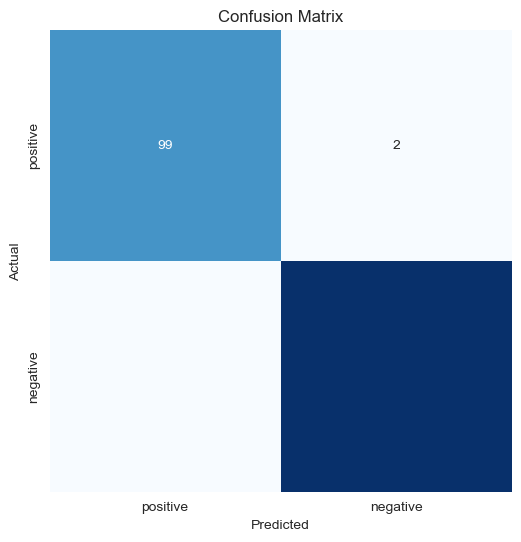

In [117]:
# Plot the confusion matrix
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=label.keys(), yticklabels=label.keys(), cbar=False, square=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Roc curve

In [122]:
rc_score = roc_auc_score(y_test, y_pred)

rc_score

0.9839261703948172

In [124]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

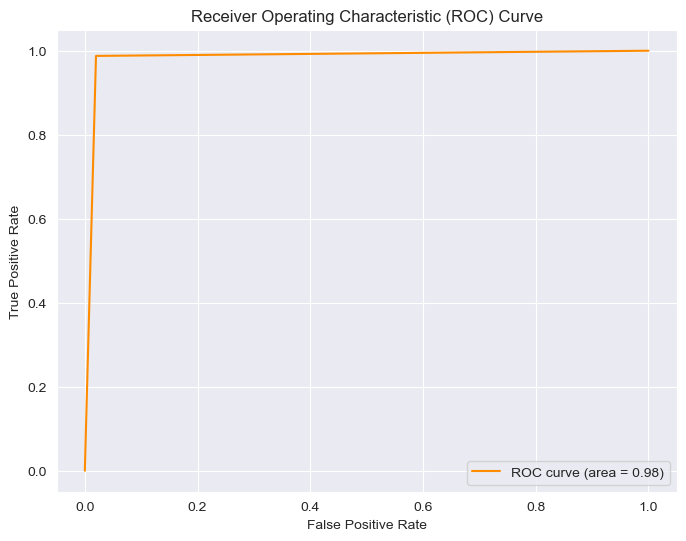

In [132]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Precision Recall Curve

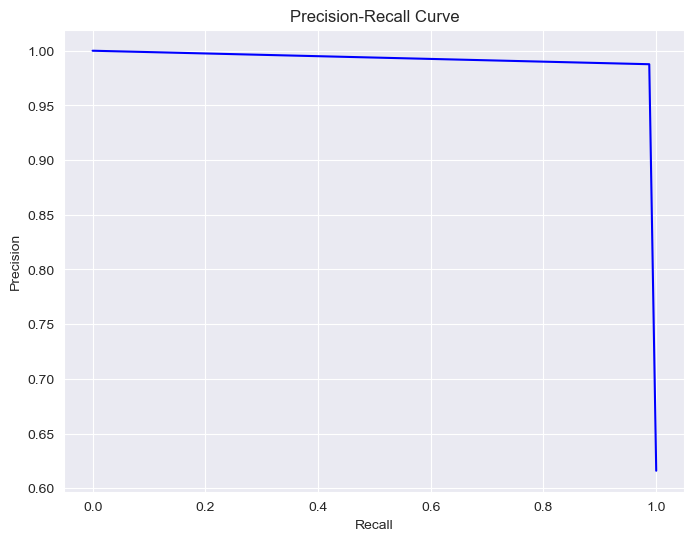

In [141]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

### Model saving and loading

In [142]:
with open('model/model.pkl', 'wb') as file:
    pickle.dump(RF, file)

In [143]:
with open('model/model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)


predictions = loaded_model.predict(X_test)
print(predictions)

[1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 0 1 1 0 0 1 1 0 0 1 1 1 0 0 1 1 1 1 1 1 0 0
 1 0 1 1 0 1 1 0 1 0 1 1 0 1 0 1 1 0 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1
 1 0 1 1 0 0 1 0 0 0 1 0 1 1 1 0 0 0 0 1 0 0 1 0 1 0 1 1 0 0 1 1 1 0 0 1 1
 1 0 1 1 0 1 1 1 0 1 1 1 0 1 0 0 0 1 1 1 0 0 0 0 0 0 1 1 0 0 1 0 1 1 1 1 1
 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 0 0 1 1 1 1 1 1 0 0 1 1 0 0 0 1 1 1 1 0 0 0
 1 0 1 0 1 1 1 1 0 1 0 0 1 0 0 1 1 1 1 1 0 0 0 0 1 0 0 1 1 1 0 1 1 0 1 1 1
 1 1 0 1 1 0 0 1 1 1 0 1 0 0 1 1 1 1 0 1 0 1 1 0 1 1 1 1 0 1 1 1 0 0 0 1 0
 1 1 1 1]
